aqui es la carga de datos

In [13]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()

df = pd.DataFrame(data)
# Mostrar las primeras filas
display(df.head())

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


transformacion

comprobacion de incoherencias en los datos

In [14]:
# Verificar si hay valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Verificar si hay filas duplicadas, excluyendo columnas de diccionario
print("\nNúmero de filas duplicadas (excluyendo columnas anidadas):")
# Excluir columnas que contienen diccionarios
cols_to_check_duplicates = [col for col in df.columns if col not in ['customer', 'phone', 'internet', 'account']]
print(df.duplicated(subset=cols_to_check_duplicates).sum())


# Verificar tipos de datos de las columnas
print("\nTipos de datos de las columnas:")
print(df.dtypes)

# Verificar valores únicos en columnas anidadas seleccionadas para posibles inconsistencias
print("\nValores únicos en subcolumnas de 'customer':")
for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    if col in df['customer'][0]:
        print(f"  {col}: {df['customer'].apply(lambda x: x.get(col)).unique()}")

print("\nValores únicos en subcolumnas de 'phone':")
for col in ['PhoneService', 'MultipleLines']:
     if col in df['phone'][0]:
        print(f"  {col}: {df['phone'].apply(lambda x: x.get(col)).unique()}")

print("\nValores únicos en subcolumnas de 'internet':")
for col in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
     if col in df['internet'][0]:
        print(f"  {col}: {df['internet'].apply(lambda x: x.get(col)).unique()}")

print("\nValores únicos en subcolumnas de 'account':")
for col in ['Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure', 'MonthlyCharges', 'TotalCharges']:
    if col in df['account'][0]:
        print(f"  {col}: {df['account'].apply(lambda x: x.get(col)).unique()}")

Valores faltantes por columna:
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64

Número de filas duplicadas (excluyendo columnas anidadas):
0

Tipos de datos de las columnas:
customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object

Valores únicos en subcolumnas de 'customer':
  gender: ['Female' 'Male']
  SeniorCitizen: [0 1]
  Partner: ['Yes' 'No']
  Dependents: ['Yes' 'No']

Valores únicos en subcolumnas de 'phone':
  PhoneService: ['Yes' 'No']
  MultipleLines: ['No' 'Yes' 'No phone service']

Valores únicos en subcolumnas de 'internet':
  InternetService: ['DSL' 'Fiber optic' 'No']
  OnlineSecurity: ['No' 'Yes' 'No internet service']
  OnlineBackup: ['Yes' 'No' 'No internet service']
  DeviceProtection: ['No' 'Yes' 'No internet service']
  TechSupport: ['Yes' 'No' 'No internet service']
  StreamingTV: ['Yes' 'No' 'No internet service']
  Str

manejo de incosistencias

In [15]:
# Función para aplanar diccionarios anidados
def flatten_dict_column(df, col_name):
    flattened_data = pd.json_normalize(df[col_name])
    flattened_data.columns = [f"{col_name}_{sub_col}" for sub_col in flattened_data.columns]
    df = df.drop(columns=[col_name])
    df = pd.concat([df, flattened_data], axis=1)
    return df

# Manejar inconsistencias en las columnas 'phone' e 'internet' antes de aplanar
# Reemplazar 'No phone service' con 'No' en 'MultipleLines'
df['phone'] = df['phone'].apply(lambda x: {k: 'No' if v == 'No phone service' else v for k, v in x.items()})

# Reemplazar 'No internet service' con 'No' en columnas relacionadas con internet
def replace_no_internet_service(internet_dict):
    for key, value in internet_dict.items():
        if value == 'No internet service':
            internet_dict[key] = 'No'
    return internet_dict

df['internet'] = df['internet'].apply(replace_no_internet_service)


# Aplanar las columnas anidadas
df = flatten_dict_column(df, 'customer')
df = flatten_dict_column(df, 'phone')
df = flatten_dict_column(df, 'internet')
df = flatten_dict_column(df, 'account')

# Mostrar las primeras filas del DataFrame aplanado
display(df.head())

# Mostrar los tipos de datos de las nuevas columnas
print("\nTipos de datos después de aplanar:")
print(df.dtypes)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4



Tipos de datos después de aplanar:
customerID                    object
Churn                         object
customer_gender               object
customer_SeniorCitizen         int64
customer_Partner              object
customer_Dependents           object
customer_tenure                int64
phone_PhoneService            object
phone_MultipleLines           object
internet_InternetService      object
internet_OnlineSecurity       object
internet_OnlineBackup         object
internet_DeviceProtection     object
internet_TechSupport          object
internet_StreamingTV          object
internet_StreamingMovies      object
account_Contract              object
account_PaperlessBilling      object
account_PaymentMethod         object
account_Charges.Monthly      float64
account_Charges.Total         object
dtype: object


Columna de cuentas diarias

In [12]:
# Calcular cargos diarios
# Asumiendo un promedio de 30.44 días por mes (365.25 / 12)
days_in_month = 365.25 / 12
df['Cuentas_Diarias'] = df['account_Charges.Monthly'] / days_in_month

# Mostrar las primeras filas con la nueva columna
display(df[['account_Charges.Monthly', 'Cuentas_Diarias']].head())

# Mostrar el tipo de dato de la nueva columna
print("\nData type of 'Cuentas_Diarias' column:")
print(df['Cuentas_Diarias'].dtypes)

,account_Charges.Monthly,Cuentas_Diarias
0,65.6,2.155236
1,59.9,1.967967
2,73.9,2.427926
3,98.0,3.219713
4,83.9,2.756468



Data type of 'Cuentas_Diarias' column:
float64


Analisis descriptivo

In [16]:
# Realizar análisis descriptivo en columnas numéricas
display(df.describe())

# Realizar análisis descriptivo en columnas categóricas
display(df.describe(include='object'))

,customer_SeniorCitizen,customer_tenure,account_Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


,customerID,Churn,customer_gender,customer_Partner,customer_Dependents,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Total
count,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267
unique,7267,3,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,6531
top,9995-HOTOH,No,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2
freq,1,5174,3675,3749,5086,6560,4202,3198,5189,4763,4776,5163,4477,4451,4005,4311,2445,11


distribucion de evasion

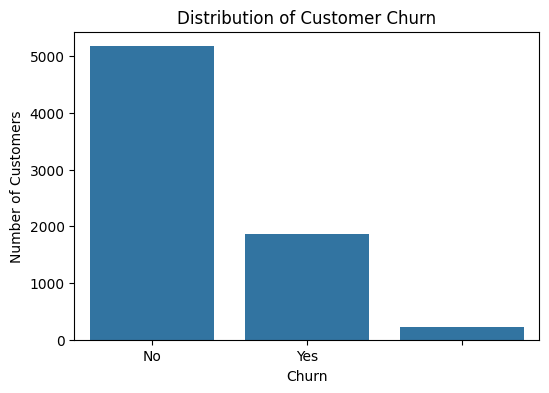


Percentage of customers by Churn:
Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el recuento de cada categoría de evasión
churn_counts = df['Churn'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_counts.index, y=churn_counts.values)
plt.title('Distribución de la Evasión de Clientes')
plt.xlabel('Evasión')
plt.ylabel('Número de Clientes')
plt.show()

# Mostrar el porcentaje de cada categoría de evasión
print("\nPorcentaje de clientes por Evasión:")
print(df['Churn'].value_counts(normalize=True) * 100)

manejo de la incosistencia "churn"

In [10]:
# Reemplazar cadenas vacías en la columna 'Churn' con 'Unknown'
df['Churn'] = df['Churn'].replace('', 'Unknown')

# Mostrar el porcentaje actualizado de cada categoría de evasión
print("\nPorcentaje de clientes por Evasión después de manejar la inconsistencia:")
print(df['Churn'].value_counts(normalize=True) * 100)


Percentage of customers by Churn after handling inconsistency:
Churn
No         71.198569
Yes        25.719004
Unknown     3.082427
Name: proportion, dtype: float64


recuento de evasion por variables categoricas

In [17]:
# Seleccionar columnas categóricas para el análisis (excluyendo 'customerID' y 'Churn')
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')
if 'account_Charges.Total' in categorical_cols:
    categorical_cols.remove('account_Charges.Total')


# Analizar la distribución de evasión para cada variable categórica
for col in categorical_cols:
    print(f"\nDistribución de evasión por {col}:")
    display(pd.crosstab(df[col], df['Churn'], normalize='index') * 100)


Distribución de evasión por customer_gender:


Churn,,No,Yes
customer_gender,,,
Female,2.895323,70.963252,26.141425
Male,3.265306,71.428571,25.306122



Distribución de evasión por customer_Partner:


Churn,,No,Yes
customer_Partner,,,
No,2.880768,65.110696,32.008536
Yes,3.297328,77.686185,19.016487



Distribución de evasión por customer_Dependents:


Churn,,No,Yes
customer_Dependents,,,
No,3.008258,66.653559,30.338183
Yes,3.255387,81.797341,14.947272



Distribución de evasión por phone_PhoneService:


Churn,,No,Yes
phone_PhoneService,,,
No,3.536068,72.418670,24.045262
Yes,3.033537,71.067073,25.899390



Distribución de evasión por phone_MultipleLines:


Churn,,No,Yes
phone_MultipleLines,,,
No,3.093765,72.655878,24.250357
Yes,3.066884,69.200653,27.732463



Distribución de evasión por internet_InternetService:


Churn,,No,Yes
internet_InternetService,,,
DSL,2.692926,78.858521,18.448553
Fiber optic,3.189493,56.253909,40.556598
No,3.478811,89.373814,7.147375



Distribución de evasión por internet_OnlineSecurity:


Churn,,No,Yes
internet_OnlineSecurity,,,
No,3.179803,66.486799,30.333398
Yes,2.839269,82.964389,14.196343



Distribución de evasión por internet_OnlineBackup:


Churn,,No,Yes
internet_OnlineBackup,,,
No,3.128280,68.612219,28.259500
Yes,2.995208,76.118211,20.886581



Distribución de evasión por internet_DeviceProtection:


Churn,,No,Yes
internet_DeviceProtection,,,
No,3.245394,69.032663,27.721943
Yes,2.769972,75.351265,21.878764



Distribución de evasión por internet_TechSupport:


Churn,,No,Yes
internet_TechSupport,,,
No,3.176448,66.627929,30.195623
Yes,2.851711,82.414449,14.733840



Distribución de evasión por internet_StreamingTV:


Churn,,No,Yes
internet_StreamingTV,,,
No,3.14943,73.285682,23.564887
Yes,2.97491,67.849462,29.175627



Distribución de evasión por internet_StreamingMovies:


Churn,,No,Yes
internet_StreamingMovies,,,
No,3.145361,73.241968,23.612671
Yes,2.982955,67.968750,29.048295



Distribución de evasión por account_Contract:


Churn,,No,Yes
account_Contract,,,
Month-to-month,3.245943,55.430712,41.323346
One year,3.028308,86.043450,10.928242
Two year,2.753873,94.492255,2.753873



Distribución de evasión por account_PaperlessBilling:


Churn,,No,Yes
account_PaperlessBilling,,,
No,2.841678,81.292287,15.866035
Yes,3.247506,64.277430,32.475064



Distribución de evasión por account_PaymentMethod:


Churn,,No,Yes
account_PaymentMethod,,,
Bank transfer (automatic),2.831970,80.931403,16.236627
Credit card (automatic),2.933673,82.270408,14.795918
Electronic check,3.271984,52.924335,43.803681
Mailed check,3.183183,78.318318,18.498498


Informe final

## Informe Final del Análisis de Evasión de Clientes (Churn)

### 1. Introducción

El presente informe tiene como objetivo analizar el problema de la evasión de clientes (Churn) en la empresa TelecomX. La evasión de clientes es un factor crítico que impacta directamente en los ingresos y el crecimiento de la empresa. Comprender los factores que influyen en la decisión de un cliente de abandonar el servicio es fundamental para implementar estrategias efectivas de retención.

El análisis se basa en el conjunto de datos proporcionado, que contiene información sobre los clientes, sus servicios telefónicos y de internet, y los detalles de su cuenta, incluyendo si han evadido o no.

### 2. Limpieza y Tratamiento de Datos

El proceso de análisis comenzó con la carga de los datos desde un archivo JSON. Los datos fueron importados y estructurados en un DataFrame de pandas.

Se realizó una verificación inicial de la calidad de los datos, incluyendo la búsqueda de valores ausentes y filas duplicadas. No se encontraron valores ausentes ni filas duplicadas en las columnas principales. Sin embargo, se identificaron inconsistencias en los valores de algunas columnas anidadas, como 'No phone service' y 'No internet service'.

Para abordar estas inconsistencias y facilitar el análisis, se procedió a:

*   Reemplazar 'No phone service' por 'No' en la columna 'MultipleLines' dentro de la estructura anidada de 'phone'.
*   Reemplazar 'No internet service' por 'No' en las columnas relacionadas con internet dentro de la estructura anidada de 'internet'.
*   Aplanar las columnas anidadas ('customer', 'phone', 'internet', 'account') para convertirlas en columnas individuales en el DataFrame principal.

Además, se creó una nueva columna llamada 'Cuentas_Diarias' calculando el cargo diario a partir del cargo mensual ('account_Charges.Monthly').

Durante el análisis de la distribución de la variable 'Churn', se identificó una categoría inconsistente representada por una cadena vacía (''). Esta inconsistencia fue manejada reemplazando las cadenas vacías por el valor 'Unknown' para una representación más clara de los datos.

Se observó que la columna `account_Charges.Total` se cargó como tipo `object` y requiere conversión a un tipo numérico para futuros análisis.

### 3. Análisis Exploratorio de Datos

Se realizó un análisis descriptivo para comprender la distribución de las variables numéricas y categóricas.

*   **Distribución de Churn:** La visualización de la distribución de la variable 'Churn' (ver [Gráfico de Distribución de Churn](https://colab.research.google.com/drive/1...#scrollTo=4S1ye0RyQ9TL)) mostró que la mayoría de los clientes no han evadido, pero existe un porcentaje significativo de clientes que sí lo han hecho, además de una pequeña proporción de clientes con estado de churn desconocido.

*   **Recuento de Evasión por Variables Categóricas:** Se analizó la distribución de la evasión a través de varias variables categóricas (ver [Tablas de Distribución de Churn por Categoría](https://colab.research.google.com/drive/1...#scrollTo=NYHhKztUR1dj)). Los hallazgos clave incluyen:
    *   Los clientes con contratos "Month-to-month" tienen una tasa de evasión significativamente más alta en comparación con aquellos con contratos de uno o dos años.
    *   Los clientes que utilizan "Electronic check" como método de pago presentan una mayor propensión a la evasión.
    *   Los clientes con servicios de internet de "Fiber optic" muestran una tasa de evasión superior a los que usan DSL o no tienen servicio de internet.
    *   La ausencia de servicios adicionales como "Online Security", "Tech Support", "Online Backup", "Device Protection", "Streaming TV", y "Streaming Movies" parece estar asociada con tasas de evasión más altas.
    *   Los clientes que no tienen pareja ('Partner') o dependientes ('Dependents') tienden a evadir más.
    *   Los clientes que optan por la facturación electrónica ('PaperlessBilling') también muestran una tasa de evasión más alta.
    *   No se observaron diferencias significativas en la tasa de evasión basadas en el género ('customer_gender') o si tienen servicio telefónico ('phone_PhoneService').

### 4. Conclusiones e Insights

El análisis exploratorio de datos ha revelado varios factores que parecen estar asociados con una mayor probabilidad de evasión de clientes:

*   **Tipo de Contrato:** Los contratos a corto plazo ('Month-to-month') son un indicador clave de riesgo de evasión.
*   **Método de Pago:** El método de pago 'Electronic check' está fuertemente correlacionado con la evasión.
*   **Servicio de Internet:** El servicio de 'Fiber optic' y la falta de servicios de seguridad y soporte en línea están relacionados con una mayor evasión.
*   **Características del Cliente:** Clientes sin pareja o dependientes, y aquellos con facturación electrónica, muestran una mayor tendencia a evadir.

Estos hallazgos sugieren que la evasión no es aleatoria y está influenciada por las características del servicio y del cliente. La empresa puede utilizar esta información para identificar a los clientes en riesgo de evasión.

### 5. Recomendaciones

Basado en los insights obtenidos, se recomiendan las siguientes estrategias para reducir la evasión de clientes:

*   **Incentivar Contratos a Largo Plazo:** Ofrecer descuentos o beneficios adicionales a los clientes que opten por contratos de uno o dos años.
*   **Promocionar Métodos de Pago Alternativos:** Fomentar el uso de otros métodos de pago, como transferencias bancarias automáticas o tarjetas de crédito, especialmente para los clientes que actualmente utilizan 'Electronic check'.
*   **Mejorar la Experiencia del Servicio de Fibra Óptica:** Investigar las posibles causas de la mayor evasión entre los usuarios de fibra óptica (por ejemplo, problemas de calidad de servicio, soporte técnico) e implementar mejoras.
*   **Ofrecer Paquetes de Servicios Adicionales:** Promocionar los servicios de seguridad en línea, soporte técnico y entretenimiento (Streaming TV/Movies) como una forma de aumentar la lealtad del cliente, especialmente para aquellos que no los tienen actualmente.
*   **Programas de Fidelización Personalizados:** Desarrollar programas de retención dirigidos a segmentos de clientes identificados con mayor riesgo, como aquellos sin pareja o dependientes, u ofrecer incentivos para la facturación no electrónica si se identifica como un factor relevante.

Implementar estas recomendaciones, respaldadas por un monitoreo continuo de las métricas de evasión, puede ayudar a TelecomX a reducir su tasa de abandono de clientes y mejorar la retención a largo plazo.